# Download dataset

In [ ]:
! pip install pytorch-gradcam

# Import dependencies

In [2]:
import os
import cv2
import numpy as np
import random

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision import utils
from torchsummary import summary
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.utils import to_categorical
from operator import truediv
import matplotlib.pyplot as plt
import seaborn as sb

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp

from google.colab import files

# Initialize constants

In [3]:
LEARNING_RATE = 0.0001
EPOCHS = 50
BATCH_SIZE = 20
NUM_OF_CLASSES = 2
LABELS = ['Non-Covid 19', 'Covid 19']
REG = 'cutout' # 'none', 'cutmix', 'mixup', 'cutout'
PRETRAIN = True
MODEL_NAME = 'resnet50' # 'alexnet', 'vgg16', 'vgg19', 'resnet18', 'resnet34', 'resnet50'
EXPERIMENTS = 1

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")
FILENAME = "_".join(['MODEL', MODEL_NAME, 'CLASSES', str(NUM_OF_CLASSES), 'REG', REG, 'PRETRAIN', str(PRETRAIN)])

NORMAL = os.path.join('Normal')
BACTERIAL = os.path.join('Pneumonia', 'Bacterial')
VIRAL = os.path.join('Pneumonia', 'Viral')
COVID_AP = os.path.join('Covid-19', 'AP')
COVID_APS = os.path.join('Covid-19', 'AP Supine')
COVID_PA = os.path.join('Covid-19', 'PA')

PT_NORMAL = os.path.join('Pretraining', 'Normal')
PT_VIRAL = os.path.join('Pretraining', 'Viral')
PT_BACTERIAL = os.path.join('Pretraining', 'Bacterial')

if not os.path.exists("Results"):
    os.makedirs("Results")

# Load and process images

In [4]:
def read_images_of_a_directory(path):
  image_files = os.listdir(path)
  images = []
  
  for i in image_files:
    img_path = os.path.join(path, i)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

  return images

In [7]:
def create_train_val_test_set():
  normal = read_images_of_a_directory(NORMAL)[:160]
  bacterial = read_images_of_a_directory(BACTERIAL)[:159]
  viral = read_images_of_a_directory(VIRAL)[:159]
  covid = read_images_of_a_directory(COVID_AP) + read_images_of_a_directory(COVID_APS) + read_images_of_a_directory(COVID_PA)

  val_images = normal[:32] + bacterial[:32] + viral[:32] + covid[:96]
  val_labels = [0] * 96 + [1] * 96

  test_images = normal[32:32+65] + bacterial[32:32+63] + viral[32:32+63] + covid[96:96+191]
  test_labels = [0] * 191 + [1] * 191

  train_images = normal[32+65:] + bacterial[32+63:] + viral[32+63:] + covid[96+191:]
  train_labels = [0] * 191 + [1] * 191

  return np.array(train_images), np.array(train_labels), np.array(val_images), np.array(val_labels), np.array(test_images), np.array(test_labels)


In [8]:
train_images, train_labels, val_images, val_labels, test_images, test_labels = create_train_val_test_set()
print(train_images.shape, train_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape)

(382, 224, 224, 3) (382,) (192, 224, 224, 3) (192,) (382, 224, 224, 3) (382,)


In [9]:
class TrainTransform(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.CenterCrop((180, 180)),
                                          transforms.RandomRotation(degrees=30),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=NUM_OF_CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample

In [10]:
class TestValTransform(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.CenterCrop((180, 180)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=NUM_OF_CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample

In [11]:
class CXRDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    data = {'image':image, 'label':label}

    if self.transform:
      data = self.transform(data)
    return data

In [12]:
def create_train_val_test_loaders(batch_size=BATCH_SIZE):  
  train_set = CXRDataset(train_images, train_labels, transform=TrainTransform())
  val_set = CXRDataset(val_images, val_labels, transform=TestValTransform())
  test_set = CXRDataset(test_images, test_labels, transform=TestValTransform())

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [13]:
train_loader, val_loader, test_loader = create_train_val_test_loaders()
for batch in test_loader:
  print(batch['image'].shape, batch['label'].shape)

torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([20, 3, 180, 180]) torch.Size([20, 2])
torch.Size([2, 3, 180, 180]) torch.Size([2, 2])


# Train-test utils

In [14]:
def random_seed(i=0):
  torch.manual_seed(i)
  np.random.seed(i)
  random.seed(i)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [15]:
def rand_bbox(size, lam):
  W = size[2]
  H = size[3]
  cut_rat = np.sqrt(1. - lam)
  cut_w = np.int(W * cut_rat)
  cut_h = np.int(H * cut_rat)

  # uniform
  cx = np.random.randint(W)
  cy = np.random.randint(H)

  bbx1 = np.clip(cx - cut_w // 2, 0, W)
  bby1 = np.clip(cy - cut_h // 2, 0, H)
  bbx2 = np.clip(cx + cut_w // 2, 0, W)
  bby2 = np.clip(cy + cut_h // 2, 0, H)

  return bbx1, bby1, bbx2, bby2

In [16]:
def cutmix(image_batch, label_batch):
  lam = np.random.uniform()

  rand_index = torch.randperm(image_batch.size()[0]).to(DEVICE)
  target_a = label_batch
  target_b = label_batch[rand_index]
  
  bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)
  image_batch[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]

  lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.size()[-1] * image_batch.size()[-2]))
  return image_batch, target_a, target_b, lam

In [17]:
def mixup(image_batch, label_batch):
  lam = np.random.uniform()

  batch_size = image_batch.size()[0]
  index = torch.randperm(batch_size).to(DEVICE)

  image_batch = lam * image_batch + (1 - lam) * image_batch[index, :]
  target_a, target_b = label_batch, label_batch[index]
  return image_batch, target_a, target_b, lam

In [18]:
def cutout(image_batch, label_batch):
  lam = np.random.uniform()
  bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch.size(), lam)

  mask = torch.ones_like(image_batch)
  mask[:, :, bbx1:bbx2, bby1:bby2] = 0

  image_batch = image_batch * mask.to(DEVICE)
  return image_batch, label_batch


In [19]:
def test_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0
  true_labels = []
  pred_labels = []

  model.eval()
  for batch in test_loader:
    image_batch = batch['image'].to(device)
    label_batch = batch['label'].to(device)
    _, label_batch = torch.max(label_batch, 1)

    y_pred = model(image_batch)
    batch_loss = criterion(y_pred, label_batch)

    _, output_labels = torch.max(y_pred, 1)
    correct = label_batch.eq(output_labels).cpu().numpy()

    test_accuracy += sum(correct)
    test_loss += batch_loss.item() * image_batch.size(0)

    true_labels += list(label_batch.cpu().numpy())
    pred_labels += list(output_labels.cpu().numpy())

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / len(test_loader.sampler)

  return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

In [20]:
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, device, save_path, reg='cutmix'):
  max_val_acc = 0

  train_losses = []
  test_losses = []
  val_losses = []

  train_accuracies = []
  test_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    val_loss = 0

    train_accuracy = 0
    test_accuracy = 0
    val_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      optimizer.zero_grad()
      if reg == 'cutmix':
        image_batch, target_a, target_b, lam = cutmix(image_batch, label_batch)
        y_pred = model(image_batch)
        batch_loss = criterion(y_pred, target_a) * lam + criterion(y_pred, target_b) * (1. - lam)
      elif reg == 'mixup':
        image_batch, target_a, target_b, lam = mixup(image_batch, label_batch)
        y_pred = model(image_batch)
        batch_loss = lam * criterion(y_pred, target_a) + (1 - lam) * criterion(y_pred, target_b)
      elif reg == 'cutout':
        image_batch, label_batch = cutout(image_batch, label_batch)
        y_pred = model(image_batch)
        batch_loss = criterion(y_pred, label_batch)
      else:
        y_pred = model(image_batch)
        batch_loss = criterion(y_pred, label_batch)
      
      batch_loss.backward()
      optimizer.step()

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()
      train_accuracy += sum(correct)
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / len(train_loader.sampler)

    average_testing_loss, average_testing_accuracy, _, _ = test_model(
        model, test_loader, 
        criterion, device
        )

    average_val_loss, average_val_accuracy, _, _ = test_model(
        model, val_loader, 
        criterion, device
        )    
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)
    val_losses.append(average_val_loss)

    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)
    val_accuracies.append(average_val_accuracy)

    # print('Epoch: {} \t Train Loss: {:.4f} \t Val Loss: {:.4f} \t Test Loss: {:.4f} \t Train Acc: {:.4f} \t Val Acc: {:.4f} \t Test Acc: {:.4f}'.format(epoch, average_training_loss, average_val_loss, average_testing_loss, average_training_accuracy, average_val_accuracy, average_testing_accuracy))
    
    if max_val_acc <= average_val_accuracy :
      print('Val Acc improved at epoch: {} \t Train Loss: {:.4f} \t Val Loss: {:.4f} \t Test Loss: {:.4f} \t Train Acc: {:.4f} \t Val Acc: {:.4f} \t Test Acc: {:.4f}'.format(epoch, average_training_loss, average_val_loss, average_testing_loss, average_training_accuracy, average_val_accuracy, average_testing_accuracy))
      max_val_acc = average_val_accuracy
      torch.save(model.state_dict(), save_path)      
  
  return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Define models

In [21]:
class Model(nn.Module):
  def __init__(self, name='alexnet', pretrained=False):
    super(Model, self).__init__()
    self.model = self.get_model(name, pretrained)

  def replace_fc(self, model):
    model.fc = nn.Linear(model.fc.in_features, NUM_OF_CLASSES)
    return model

  def replace_classifier_0(self, model):
    model.classifier = nn.Linear(model.classifier[0].in_features, NUM_OF_CLASSES)
    return model

  def replace_classifier_1(self, model):
    model.classifier = nn.Linear(model.classifier[1].in_features, NUM_OF_CLASSES)
    return model

  def get_model(self, name, pretrained):
    mapping = {
        'alexnet' : {
            'model' : models.alexnet,
            'replace' : self.replace_classifier_1
        },
        'vgg16' : {
            'model' : models.vgg16_bn,
            'replace' : self.replace_classifier_0
        },
        'vgg19' : {
            'model' : models.vgg19_bn,
            'replace' : self.replace_classifier_0
        },
        'resnet18' : {
            'model' : models.resnet18,
            'replace' : self.replace_fc
        },
        'resnet34' : {
            'model' : models.resnet34,
            'replace' : self.replace_fc
        },
        'resnet50' : {
            'model' : models.resnet50,
            'replace' : self.replace_fc
        }
    }

    # if name=='googlenet':
    #   model = mapping[name]['replace'](mapping[name]['model'](pretrained=pretrained, aux_logits=False))
    # else:

    model = mapping[name]['replace'](mapping[name]['model'](pretrained=pretrained))
    return model

  def forward(self, x):
    x = self.model(x)
    return x

# Training

In [22]:
for i in range(EXPERIMENTS):
  print("Starting Experiment -- " + str(i+1))
  random_seed(i)

  model = Model(name=MODEL_NAME, pretrained=PRETRAIN).to(DEVICE)

  train_loader, val_loader, test_loader = create_train_val_test_loaders(batch_size=BATCH_SIZE)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

  save_path = FILENAME + '_WEIGHTS_EXPERIMENT_' + str(i+1) + '.pt'

  train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
        model=model, 
        train_loader=train_loader, 
        val_loader=val_loader,
        test_loader=test_loader, 
        optimizer=optimizer, 
        criterion=criterion, 
        epochs=EPOCHS, 
        device=DEVICE,
        save_path=save_path,
        reg=REG
        )
  print("")

Starting Experiment -- 1


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Val Acc improved at epoch: 0 	 Train Loss: 0.3465 	 Val Loss: 0.0495 	 Test Loss: 0.0355 	 Train Acc: 0.8639 	 Val Acc: 0.9844 	 Test Acc: 0.9921
Val Acc improved at epoch: 1 	 Train Loss: 0.1233 	 Val Loss: 0.0438 	 Test Loss: 0.0311 	 Train Acc: 0.9503 	 Val Acc: 0.9948 	 Test Acc: 0.9974
Val Acc improved at epoch: 2 	 Train Loss: 0.0551 	 Val Loss: 0.0487 	 Test Loss: 0.0416 	 Train Acc: 0.9869 	 Val Acc: 0.9948 	 Test Acc: 0.9869
Val Acc improved at epoch: 7 	 Train Loss: 0.0688 	 Val Loss: 0.0206 	 Test Loss: 0.0117 	 Train Acc: 0.9712 	 Val Acc: 0.9948 	 Test Acc: 0.9948
Val Acc improved at epoch: 8 	 Train Loss: 0.0409 	 Val Loss: 0.0348 	 Test Loss: 0.0570 	 Train Acc: 0.9843 	 Val Acc: 0.9948 	 Test Acc: 0.9843
Val Acc improved at epoch: 9 	 Train Loss: 0.0387 	 Val Loss: 0.0282 	 Test Loss: 0.0371 	 Train Acc: 0.9843 	 Val Acc: 0.9948 	 Test Acc: 0.9869
Val Acc improved at epoch: 11 	 Train Loss: 0.0680 	 Val Loss: 0.0368 	 Test Loss: 0.0912 	 Train Acc: 0.9764 	 Val Acc: 0.

# Testing and visualization

In [23]:
def generate_acc_plots(filename="file"):
  filename = os.path.join("Results", filename)

  # plt.grid(None)  
  plt.figure(figsize=(8, 6))
  sb.set(font_scale=1.3)

  plt.plot(list(range(EPOCHS)), train_accuracies, 'r-', linewidth=3, label='Train Accuracy')
  plt.plot(list(range(EPOCHS)), val_accuracies, 'b-', linewidth=3, label='Val Accuracy')
  plt.plot(list(range(EPOCHS)), test_accuracies, 'g-', linewidth=3, label='Test Accuracy')
  
  plt.legend(loc='best')
  plt.savefig(filename + '_accuracy.png', bbox_inches='tight')

  plt.show()

In [24]:
def generate_loss_plots(filename="file"):
  filename = os.path.join("Results", filename)

  # plt.grid(None)
  plt.figure(figsize=(8, 6))  
  sb.set(font_scale=1.3)

  plt.plot(list(range(EPOCHS)), train_losses, 'r-', linewidth=3, label='Train Loss')
  plt.plot(list(range(EPOCHS)), val_losses, 'b-', linewidth=3, label='Val Loss')
  plt.plot(list(range(EPOCHS)), test_losses, 'g-', linewidth=3, label='Test Loss')
  
  plt.legend(loc='best')
  plt.savefig(filename + '_loss.png', bbox_inches='tight')

  plt.show()

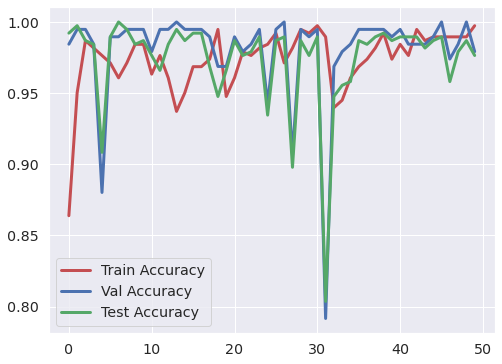

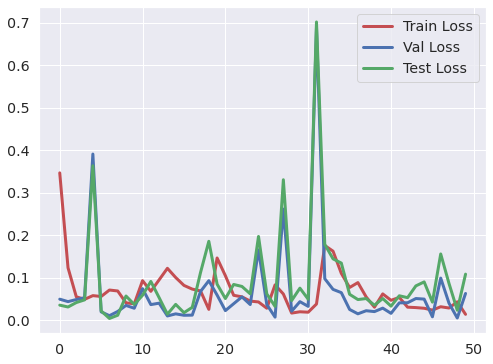

In [25]:
generate_acc_plots(FILENAME)
generate_loss_plots(FILENAME)

In [26]:
def ClassWiseAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    each_acc_dict = dict(zip(LABELS, each_acc*100))

    return each_acc_dict

In [27]:
def reports(y_pred, y_true):    
    c_report = classification_report(y_true, y_pred, digits=4, target_names=LABELS)
    accuracy = accuracy_score(y_true, y_pred)

    confusion = confusion_matrix(y_true, y_pred)
    each_acc = ClassWiseAccuracy(confusion)

    return c_report, confusion, accuracy*100, each_acc

In [28]:
def generate_results(c_report, each_acc, accuracy, file_name = "classification_report.txt"):

  file_name = os.path.join("Results", file_name)

  c_report = str(c_report)
  each_acc = str(each_acc)

  with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Accuracy is (%)'.format(accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Classification Report - \n')
    x_file.write('{}'.format(c_report))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Class-Wise Accuracies - \n')
    x_file.write('{}'.format(each_acc))

In [29]:
def generate_averaged_accuracies(accuracies, each_accs, file_name = "average_report.txt"):
  file_name = os.path.join("Results", file_name)

  acc_mean = round(np.mean(accuracies), 2)
  acc_std = round(np.std(accuracies), 1)

  each_accs_mean = [round(n, 2) for n in np.mean(np.array(each_accs), axis=0)]
  each_accs_std = [round(n, 1) for n in np.std(np.array(each_accs), axis=0)]

  with open(file_name, 'w') as x_file:
      x_file.write('\n')
      x_file.write('${} \pm {}$ Overall accuracy (%)'.format(acc_mean, acc_std))
      x_file.write('\n')
      x_file.write('Class-Wise Accuracies are as follows : \n \n')

      for c in range(NUM_OF_CLASSES):         
        x_file.write('{} - ${} \pm {}$ \n'.format(LABELS[c], each_accs_mean[c], each_accs_std[c]))
 

In [30]:
def generate_confusion_matrix(cm, filename="cm.png"):
  filename = os.path.join("Results", filename)
  sb.set(font_scale=1.5)

  plt.figure(figsize=(4, 4))
  plt.axis('on')
  sb.heatmap(cm, fmt="d", annot=True, linewidths=0, xticklabels=LABELS, yticklabels=LABELS) #fmt="d"

  plt.savefig(filename, bbox_inches='tight')
  plt.show()

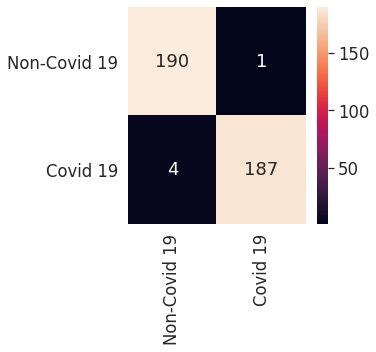

Generated results for Experiment 1
Overall results generated !


In [31]:
accuracies = []
each_accs = []

for e in range(EXPERIMENTS):
  # model = Model(name=MODEL_NAME, pretrained=PRETRAIN).to(DEVICE)
  weights_path = FILENAME + '_WEIGHTS_EXPERIMENT_' + str(e+1) + '.pt'
  model.load_state_dict(torch.load(weights_path))

  _, _, y_true, y_pred = test_model(
        model=model, 
        test_loader=test_loader, 
        criterion=criterion, 
        device=DEVICE
        )

  c_report, confusion, accuracy, each_acc = reports(y_pred, y_true)

  accuracies.append(accuracy)
  each_accs.append(list(each_acc.values()))

  generate_results(c_report, each_acc, accuracy, file_name=FILENAME+'_EXPERIMENT_'+str(e+1)+'.txt')
  generate_confusion_matrix(confusion, filename=FILENAME+'_EXPERIMENT_CM_'+str(e+1)+'.png')
  print("Generated results for Experiment "+str(e+1))

generate_averaged_accuracies(accuracies, each_accs, file_name = FILENAME+'_AVERAGED_RESULTS_.txt')
print("Overall results generated !")

In [32]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [33]:
def get_feature_length():
  feature = {
      'alexnet' : 9216,
      'vgg16' : 25088,
      'vgg19' : 25088,
      'resnet18' : 512,
      'resnet34' : 512,
      'resnet50' : 2048,
    }
  return feature[MODEL_NAME]

In [34]:
# model = Model(name=MODEL_NAME, pretrained=PRETRAIN).to(DEVICE)
weights_path = FILENAME+'_WEIGHTS_EXPERIMENT_1.pt'
model.load_state_dict(torch.load(weights_path))

model.model.avgpool.register_forward_hook(get_activation('avgpool'))
features = np.empty((0, get_feature_length()))
labels = np.empty((0))

In [35]:
model.eval()
with torch.no_grad():
  for batch in test_loader:
      image_batch = batch['image'].to(DEVICE)
      label_batch = batch['label'].to(DEVICE)
      
      output = model(image_batch)
      _, batch_labels = torch.max(label_batch, 1)

      batch_features = activation['avgpool'].view(image_batch.size(0), -1).cpu().numpy()
      batch_labels = [LABELS[int(l)] for l in batch_labels.cpu().numpy()]

      features = np.concatenate((features, batch_features))
      labels = np.concatenate((labels, batch_labels))

In [36]:
tsne = TSNE(n_components=2, perplexity=50).fit_transform(features)

In [37]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def generate_tsne_plot(tsne, filename='Tsne.png'):
  filename = os.path.join("Results", filename)

  tx = tsne[:, 0]
  ty = tsne[:, 1]

  tx_scaled = scale_to_01_range(tx)
  ty_scaled = scale_to_01_range(ty)

  plt.figure(figsize=(6, 6))
  sb.set(font_scale=1.2)

  sb.scatterplot(tx_scaled, ty_scaled, hue=labels, legend='full', palette=sb.color_palette("bright", NUM_OF_CLASSES))
  plt.legend(loc='best') #, bbox_to_anchor=(1, 0.5)
  plt.grid(b=None)

  plt.savefig(filename, bbox_inches='tight') #, bbox_inches='tight'
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


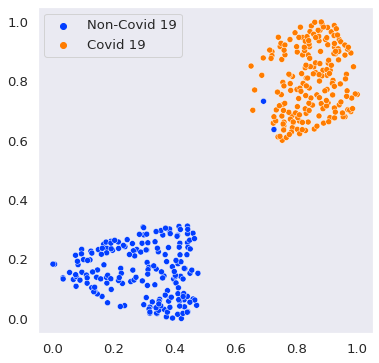

In [38]:
generate_tsne_plot(tsne, filename=FILENAME+'_EXPERIMENT_1_TSNE.png')

## Grad-CAM

In [39]:
def read_cam_image(image):

  torch_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((180, 180)),
    transforms.ToTensor(),
  ])(image).to(DEVICE)

  normed_torch_img = transforms.Normalize(
      [0.485, 0.456, 0.406], 
      [0.229, 0.224, 0.225])(torch_img)[None]

  return torch_img, normed_torch_img

In [40]:
def get_target_layer():
  layers = []
  for i in model.model.children():
    layers.append(i)

  # if MODEL_NAME == 'googlenet':
  #   if PRETRAIN:
  #     return layers[-6]
  #   else:
  #     return layers[-4]
  
  return layers[-3]

In [41]:
def generate_gradcam(model, number_of_images, columns, figsize, label=0, filename="CAM.png"):
  filename = filename + "_CLASS_" + LABELS[label] + ".png"
  filename = os.path.join("Results", filename)
  indices = np.arange(train_images.shape[0])
  np.random.shuffle(indices)

  images = train_images[indices]
  labels = train_labels[indices]  
  images = [images[i] for i in range(images.shape[0]) if labels[i] == label]

  print("CAM visualization for " + LABELS[label] + " images")
  images_cam = []

  for index in range(number_of_images):
    torch_img, normed_torch_img = read_cam_image(images[index])

    target_layer = get_target_layer() #model.model.avgpool
    gradcam = GradCAMpp(model, target_layer)
    mask, _ = gradcam(normed_torch_img)

    heatmap, result_cam = visualize_cam(mask, torch_img)
    images_cam.append(utils.make_grid([torch_img.cpu(), result_cam], nrow=3, padding=1))

  image_grid = utils.make_grid(images_cam, nrow=columns, padding=5, pad_value=1)

  plt.figure(figsize=figsize)
  plt.imshow(transforms.ToPILImage()(image_grid))

  plt.axis('off')
  plt.savefig(filename, bbox_inches='tight')
  plt.show()

  return image_grid

CAM visualization for Non-Covid 19 images


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


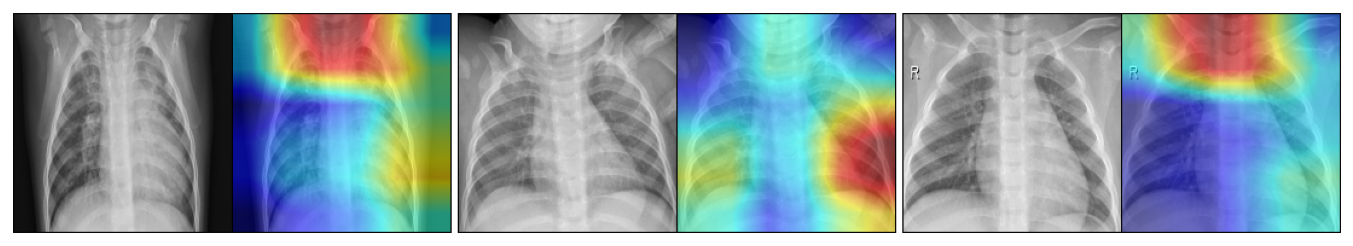

In [42]:
image_grid = generate_gradcam(model, number_of_images=3, columns=3, figsize=(24, 6), label=0, filename=FILENAME)

CAM visualization for Covid 19 images


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


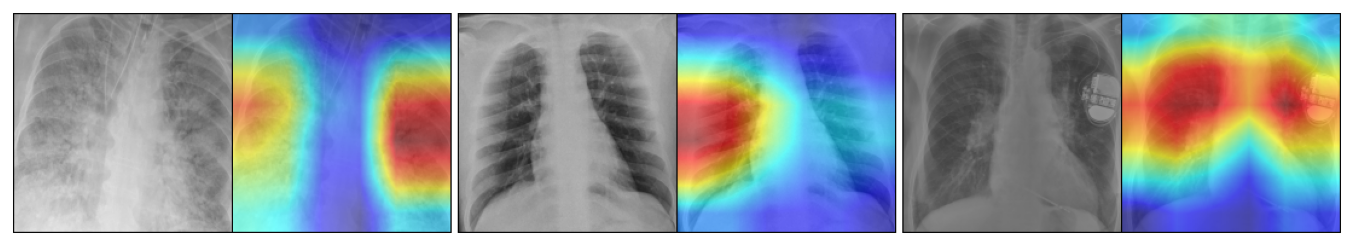

In [43]:
image_grid = generate_gradcam(model, number_of_images=3, columns=3, figsize=(24, 6), label=1, filename=FILENAME)